In [1]:
import torch
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
gpu = torch.device("cuda:0")
print(torch.cuda.get_device_name(0))

# Use smaller network for testing - ex 2000 neurons
# Even for the project, doing it for 10^6 neurons would take too long
# Problem this creates: test network is denser than actual network b/c we have 10^3 neurons but 10^2 connections per neuron
num_neurons = 2000
num_i = int(0.1 * num_neurons)
num_e = int(0.9 * num_neurons)

# Num excitatory inputs and inhibitory inputs to each neuron (in reality it should be 500 but we reduce it here to make things faster)
k = 100

# Number of olfactory bulb channels (glomeruli) to each neuron
D = 10 ** 3
# For each neuron, how many glomeruli inputs it receives (should be 10^2)
num_channel_inputs = 100

# Channel signal if not active for odor a
i_0 = 2.
# Channel signal if active for odor a
i_1 = 10.
# Probability that a channel is active for an odor a
f = 0.1
# Number of odors
P = 16
# Novel activity is up to P // 2, and familiar activity is after
novel_inds = torch.arange(0, P // 2)
familiar_inds = torch.arange(P // 2, P)

NVIDIA GeForce RTX 3060


In [3]:
# Creates sparse adjacency matrix with the given probability of edge connection and size mxn
def create_adj_matrix(p, m, n):
    # num_connections = int(p * m * n)
    # m_coords = torch.randint(0, m, (num_connections,))
    # n_coords = torch.randint(0, n, (num_connections,))
    # indices = torch.vstack((m_coords, n_coords))
    # values = torch.ones(num_connections)
    # A_mn = torch.sparse_coo_tensor(indices, values, (m, n))
    probs = torch.ones(m, n) * p
    A_mn = torch.bernoulli(probs)
    return A_mn

In [4]:
# New way of generating correlations between odors: we want different sets of odors to be correlated differently, so that when we subtract each neuron's mean activity over odors, it doesn't cancel out the variation between odors (if all the odors are correlated the same, they will tend to produce similar values for a single neuron and therefore subtracting by the mean will remove these values and only leave small fluctuations)
# So we sample a small set of odors P' and make them linearly independent, and then by multiplying by a P'x P gaussian matrix we project into mitral cell activity space for all P odors, basically making the P odors a linear combination of the set of P' odors (the smaller P' is, the more correlated the resulting set of P odors will be)
# We also scale the variance depending on how small P' is, so we will maintain differently correlated odors, just with higher total correlation if P' is small

In [5]:
P_prime = 4
def correlated_mitral_activity():
    # Each of the P' odors is independent (correlation of 0)
    sigma_p_prime = torch.zeros((P_prime, P_prime)).fill_diagonal_(1)
    dist = torch.distributions.MultivariateNormal(torch.zeros(P_prime), sigma_p_prime)
    p_prime_activity = dist.sample(torch.Size([D]))
    var = 1 / P_prime
    projection = torch.normal(torch.zeros((P_prime, P)), torch.ones(P_prime, P) * np.sqrt(var))
    activity = p_prime_activity @ projection
    return activity.to(gpu)

In [6]:
# Takes in mitral activity I and computes feedforward activity h_bar_ff
def compute_feedforward_activity(I):
    # Probability that a channel weight will be nonzero
    p = num_channel_inputs / D
    # Only the first 0.9 * n rows should have this bernoulli number, the rest should be 0 b/c they don't receive a channel input
    # Check whether each neuron still receives ~10^2 nonzero inputs or what the distribution actually looks like
    # Because when we calculate the adjacency matrix we don't go by row (e.g ensuring each neuron has these ~10^2 connections)
    # Alternative: sample from Binomial distribution w/ mean 100
    # The output n for each row is the number of nonzero inputs, and you choose a random subset n of the indices for that row and make them 1
    with torch.device(gpu):
        a = create_adj_matrix(p, num_e, D)
        # Inhibitory neurons don't receive channel input
        # This is the first simplification, where we neglect the first inhibitory layer I_ff
        b = torch.zeros(size=(num_i, D))
        W_ff = torch.cat(tensors=(a, b), dim=0)
        
        h_ff = (W_ff @ I) * (1 / np.sqrt(num_channel_inputs))
        h_bar_ff = torch.zeros_like(h_ff)
        h_bar_ff[:num_e] = h_ff[:num_e] - torch.mean(h_ff[:num_e], dim=0, keepdim=True)
    return h_bar_ff

In [7]:
def compute_initial_recurrent_weights():
    k_ee = k_ei = k_ie = k_ii = k
    #p_ee = k_ee / num_e
    # k inhibitory inputs to that e neuron, out of num_i total inhibitory neurons gives the connection probability per neuron
    p_ei = k_ei / num_i
    p_ie = k_ie / num_e
    #p_ii = k_ii / num_i
    
    # Constants
    #w_ee = 0.1
    w_ei = 0.2
    w_ie = 0.5
    #w_ii = 0.3
    # Ignore ee and ii weights for now:
    p_ee = p_ii = w_ee = w_ii = 0
    with torch.device(gpu):
        W_ee = create_adj_matrix(p_ee, num_e, num_e) * w_ee
        W_ei = create_adj_matrix(p_ei, num_e, num_i) * -w_ei
        W_ie = create_adj_matrix(p_ie, num_i, num_e) * w_ie
        W_ii = create_adj_matrix(p_ii, num_i, num_i) * -w_ii
        
        # Concat
        W_1 = torch.cat(tensors=(W_ee, W_ei), dim=1)
        W_2 = torch.cat(tensors=(W_ie, W_ii), dim=1)
        W_rec = torch.cat(tensors=(W_1, W_2), dim=0)
    
    return W_rec

In [8]:
# Computes activation threshold for neurons, right now set it at 0
def compute_threshold():
    threshold = torch.zeros((num_neurons, P), device=gpu)
    # Since inhibitory neurons are linear
    threshold[num_e:, :] = 0
    return threshold

In [9]:
# ReLU for excitatory, linear for inhibitory
def neuron_activations(X):
    # Mask to keep excitatory
    mask1 = torch.ones((num_neurons, 1), device=gpu)
    mask1[num_e:, :] = 0
    # Mask to keep inhibitory
    mask2 = torch.zeros((num_neurons, 1), device=gpu)
    mask2[num_e:, :] = 1
    return (torch.relu(X) * mask1) + (X * mask2)

In [10]:
# Computes R for each odor, with the activation threshold theta
def compute_piriform_response(h_bar_ff, W_rec):
    # The coefficient of x_bar
    tau = 1
    # time step
    dt = 0.1
    # Number of time steps
    T = 200
    
    # Initial condition where states are gaussian
    mu_0 = 0.
    sigma_0 = 0.2
    X_0 = torch.normal(mu_0, sigma_0, size=(num_neurons, P))
    X = X_0.to(gpu)
    
    pts = []
    for i in range(T-2):
        with torch.no_grad():
            part1 = -1 * X
            part2 = (W_rec @ neuron_activations(X)) * (1 / np.sqrt(k))
            part3 = h_bar_ff
            dXdt = (1 / tau) * (part1 + part2 + part3)
            X = X + (dXdt * dt)
        # Look at convergence pattern for first odor, assuming that it'll
        # be similar across odors (since they are all independent)
        #pts.append(torch.mean(dXdt, dim=0)[0].item())
   
    # On the last 2 iterations only, track the gradient
    X.requires_grad_(True)
    
    for j in range(2):
        part1 = -1 * X
        part2 = (W_rec @ neuron_activations(X)) * (1 / np.sqrt(k))
        part3 = h_bar_ff
        dXdt = (1 / tau) * (part1 + part2 + part3)
        X = X + (dXdt * dt)
    
    # The total input to the neuron at this last time step (should be equivalent to the resulting value of X after this time step, since dxdt = 0 after the recurrent network converges)
    #total_input = part2 + part3
    threshold = compute_threshold()
    
    # Plot derivatives to see if state converged
    # plt.plot(torch.arange(T-2), pts)
    # plt.show()
    R = neuron_activations(X - threshold)
    
    return R

In [11]:
# Start and stop indices for the section of W_rec we want to update, respectively 
# Takes in R_alpha, a vector of neuron responses to a particular odor
def compute_update(model: torch.nn.Sequential, R_alpha: torch.Tensor, update_inds) -> torch.Tensor:
    # Compute the same pairs of R_i and R_j for every odor
    # 1D vectors of the pre and postsynaptic neurons corresponding to the nonzero weights of W_rec
    postsyn_responses = R_alpha[update_inds[0]]
    presyn_responses = R_alpha[update_inds[1]]
    model_input = torch.vstack((presyn_responses, postsyn_responses)).t()
    slice_updates = model(model_input)
    
    updates = slice_updates.squeeze(dim=1)
    
    return updates

In [12]:
def odor_corrs(R):
    # We don't care about the actual responses per odor, just about a neuron's fluctuations around its mean response across odors
    R_adjusted = R[:num_e, familiar_inds] - torch.mean(R[:num_e, familiar_inds], dim=1, keepdim=True)
    # Each odor becomes a variable, because we want to calculate correlations between them across neurons
    R_adjusted.t_()
    # Like cov but divides by standard deviations, effectively normalizing the values (the diagonals of the resulting matrix become 1)
    sigma_E = torch.corrcoef(R_adjusted)
    # We only care about the correlations between the familiar odors
    familiar_corrs = sigma_E - torch.eye(P // 2, device=gpu)
    corr_sum = torch.sum(familiar_corrs ** 2)
    avg_corr = torch.mean(torch.abs(familiar_corrs))
    
    return corr_sum, avg_corr

In [13]:
# Sparsity per odor, across all (E) neurons
def sparsity_per_odor(R):
    # Epsilon for if we have zero responses
    eps = 1e-6
    sp_per_odor = 1 - ((torch.sum(R[:num_e], dim=0) ** 2 + eps) / (num_e * (torch.sum(R[:num_e] ** 2, dim=0)) + eps))
    # Sparsity nan means that the responses were all 0 for an odor, meaning that its max sparsity of 1
    return sp_per_odor

# Sparsity per (E) neuron, across a given odor family
def sparsity_per_neuron(R, odor_inds):
    sp_per_neuron = 1 - (
                (torch.sum(R[:num_e, odor_inds], dim=1) ** 2) / ((P // 2) * torch.sum(R[:num_e, odor_inds] ** 2, dim=1)))
    return sp_per_neuron

In [14]:
# Try to minimize the correlations between values
def loss_fn(R, lambda_corr, lambda_i, lambda_mu, lambda_var, lambda_sp, do_print=True):
    corr_sum, avg_corr = odor_corrs(R)
    corr_loss = (1 / P) * corr_sum
    corr_term = lambda_corr * corr_loss
    
    means = torch.mean(R, dim=0)
    means_novel = torch.mean(means[novel_inds])
    means_familiar = torch.mean(means[familiar_inds])
    mu_term = lambda_mu * (((means_familiar - means_novel) / (means_novel + means_familiar)) ** 2)
    
    vars = torch.var(R, dim=0)
    var_novel = torch.mean(vars[novel_inds])
    var_familiar = torch.mean(vars[familiar_inds])
    var_term = lambda_var * (((var_familiar - var_novel) / (var_novel + var_familiar)) ** 2)
    
    sparsities = sparsity_per_odor(R)
    spars_novel = torch.mean(sparsities[novel_inds])
    spars_familiar = torch.mean(sparsities[familiar_inds])
    spars_term = lambda_sp * (((spars_familiar - spars_novel) / (spars_novel + spars_familiar)) ** 2)

    sum_i = torch.sum(R[num_e:, :] ** 2) / (num_i * P)
    i_term = lambda_i * sum_i
    
    if do_print:
        #print("Avg Corr: %.4f, Corr: %.4f, Mu: %.4f, Var: %.4f, Sparsity: %.4f" % (avg_corr, corr_term, mu_term, var_term, spars_term))
        print("Avg Corr: %.4f, Corr: %.4f, I: %.4f, Sparsity: %.4f" % (avg_corr, corr_term, i_term, spars_term))
    loss = corr_term + i_term + mu_term + var_term + spars_term
    return loss

In [15]:
mult = 100
w_ie = 0.5
ie_max_weight = mult * w_ie
ie_min_weight = 0

w_ei = -0.2
ei_max_weight = 0
ei_min_weight = mult * w_ei

ie_post = (num_e, num_neurons)
ie_pre = (0, num_e)

ei_post = (0, num_e)
ei_pre = (num_e, num_neurons)

def run_model():
    W_initial = compute_initial_recurrent_weights()
        
    i = correlated_mitral_activity()
    hbar_ff = compute_feedforward_activity(i)   
    R_initial = compute_piriform_response(hbar_ff, W_initial)
    
    _, avg_corr = odor_corrs(R_initial)
    print(f"Avg corr: {avg_corr}", end="")
    
    odor_corrs(R_initial)
    
    return W_initial, R_initial

In [16]:
W_initial, R_initial = run_model()

Avg corr: 0.2686738669872284

In [17]:
def generate_response_plots(R):
    rows, cols = 4, 4
    size=10
    fig, ax = plt.subplots(nrows=rows, ncols=cols, constrained_layout=True, sharey=True, figsize=(size, size))
    for i in range(rows):
        for j in range(cols):
            #R_plot = R[:num_e, i*rows + j][torch.nonzero(R[:num_e, i*rows + j], as_tuple=True)]
            R_plot = R[:num_e, i*cols + j]
            ax[i, j].hist(R_plot, bins=50, histtype="step", cumulative=True)
            coding_level = torch.count_nonzero(R[:num_e, i*cols + j]).item() / num_e
            ax[i, j].text(0.2, 0.5, f"Coding level: {coding_level:.3f}", fontsize=10, transform=ax[i, j].transAxes)
            ax[i, j].set_title(f"Odor {i*cols + j}")
            

    fig.suptitle("Cumulative Dist of Excitatory Responses per Odor")
    plt.show()

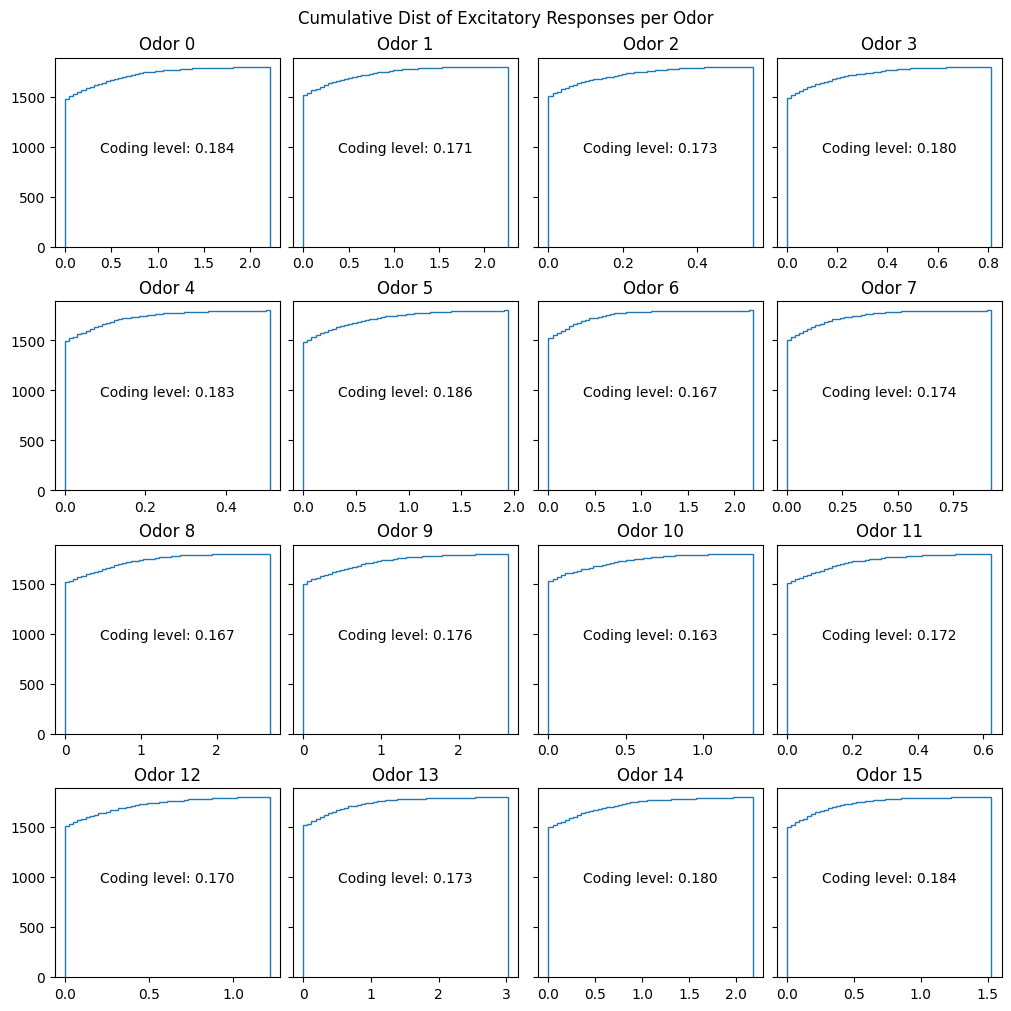

In [18]:
generate_response_plots(R_initial.detach().cpu())